In [35]:
# Imaging stuff
from PIL import Image
from IPython.display import display

# Math Stuff
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from scipy import ndimage

# Useful stuff
import os
import copy
import time

# DL Stuff
import torch 
from torch import nn, optim
from torchvision import transforms, utils
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


In [36]:
# Tell pytorch to run matrix calculations on the GPU
device = torch.device("cuda:0")

In [136]:
!ls

NN_Adding.ipynb   resnet_34_planet_challenge_20_epochs.pt  test-jpg-additional
predictions1.csv  resnet_34_planet_challenge_30_epochs.pt  train-jpg
predictions2.csv  SatelliteImageClassification.ipynb	   train_v2.csv
README.md	  test-jpg


In [38]:
# load the training dataset
labels = pd.read_csv("train_v2.csv")
labels.shape

(40479, 2)

In [39]:
labels.set_index('image_name', inplace=True)

In [40]:
# Run this to view a random image.
index = random.randint(0, labels.shape[0])
filename = 'train-jpg/train_' + str(index) + ".jpg"
im = Image.open(filename, 'r').convert('RGB')
im = np.asarray(im)

print(labels.iloc[index])

tags    clear primary water
Name: train_14432, dtype: object


In [41]:
labels.iloc[:10]

,tags
image_name,
train_0,haze primary
train_1,agriculture clear primary water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear habitation primary road
train_5,haze primary water
train_6,agriculture clear cultivation primary water
train_7,haze primary
train_8,agriculture clear cultivation primary


In [42]:
# Reduce the size of the Dataset (for faster training while prototyping)
labels = labels.iloc[:]

In [43]:
# Get one-hot encodng for all samples.
def one_hot_encode(tags):
    possible_labels = ["agriculture", "artisinal_mine", "bare_ground", "blooming", "blow_down", "clear", "cloudy", "conventional_mine", "cultivation", "habitation", "haze", "partly_cloudy", "primary", "road", "selective_logging", "slash_burn", "water"]
    output = [(1.0 if label in tags.split(" ") else 0.0) for label in possible_labels]
    return output

labels['one_hot'] = list(map(one_hot_encode, labels['tags']))


In [44]:
labels

,tags,one_hot
image_name,,
train_0,haze primary,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
train_1,agriculture clear primary water,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
train_2,clear primary,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
train_3,clear primary,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
train_4,agriculture clear habitation primary road,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
train_5,haze primary water,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
train_6,agriculture clear cultivation primary water,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
train_7,haze primary,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
train_8,agriculture clear cultivation primary,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."


In [45]:
# Keep 80% for training
mask = np.random.randn(labels.shape[0]) < 0.8
train = labels.iloc[mask]

# The other 20% is used for validation
validation = labels.iloc[~mask]


In [ ]:
train_transformer = transforms.Compose([
    transforms.Resize(224),              # resize the image to 64x64 
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])             # transform it into a PyTorch Tensor

eval_transformer = transforms.Compose([
    transforms.Resize(224),              # resize the image to 64x64 
    transforms.ToTensor()])             # transform it into a PyTorch Tensor

In [46]:
# This stuff comes from here: https://cs230-stanford.github.io/pytorch-vision.html

class PlanetDataset(Dataset):
    
    # Each dataset is a list of filenames with their corresponding one-hot encodings
    # calling an image returns a randomly transformed version of the image itself.
    
  def __init__(self, directory, input_df, transform):      
    # store filenames
    self.filenames = input_df.index.values
    self.filenames = [(os.path.join(directory, f) + ".jpg") for f in self.filenames]
      
    # the first character of the filename contains the label
    self.labels = list(input_df['one_hot'])
    self.transform = transform
      
  def __len__(self):
    # return size of dataset
    return len(self.filenames)
      
  def __getitem__(self, idx):
    # open image, apply transforms and return with label
    image = Image.open(self.filenames[idx])  # PIL image
    image = self.transform(image)[:3]
    return image, torch.FloatTensor(self.labels[idx])

## Defining the Model:

We will use a ResNet34 Architecture ([Learn more here!](https://arxiv.org/pdf/1512.03385.pdf)) for labelling satellite images.Pytorch offers a pre-trained model which we can easily customize by re-training the last layer and adding a 17-bit binary output to correspond to the 17 possible labels we are trying to assign.

In [48]:
train_dataset = PlanetDataset('train-jpg', input_df=train, transform=train_transformer)
val_dataset = PlanetDataset('train-jpg', input_df=validation, transform=eval_transformer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [49]:
# TODO: find out how to display a pytorch image tensor (3x64x64)

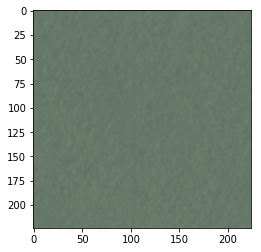

In [50]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    mean = np.array([0.1, 0.1, 0.1])
    std = np.array([0.4, 0.5, 0.4])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

image = train_dataset[random.randint(0,1000)][0]
imshow(image)


In [51]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()
    dataset_sizes = {'train':len(train_dataloader)*32, 'val':len(val_dataloader)*32}
    
    loss_logs = {'train':[], 'val':[]}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            
            loss_logs[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights (NVM skip this.. its broken?)
    # model.load_state_dict(best_model_wts)
    return model, loss_logs

In [56]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 17)
    
criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

model = model.cuda()

In [127]:
model, logs = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0602
val Loss: 0.0546

Epoch 1/9
----------
train Loss: 0.0598
val Loss: 0.0545

Epoch 2/9
----------
train Loss: 0.0600
val Loss: 0.0540

Epoch 3/9
----------
train Loss: 0.0594
val Loss: 0.0544

Epoch 4/9
----------
train Loss: 0.0589
val Loss: 0.0534

Epoch 5/9
----------
train Loss: 0.0590
val Loss: 0.0539

Epoch 6/9
----------
train Loss: 0.0586
val Loss: 0.0535

Epoch 7/9
----------
train Loss: 0.0587
val Loss: 0.0531

Epoch 8/9
----------
train Loss: 0.0583
val Loss: 0.0529

Epoch 9/9
----------
train Loss: 0.0585
val Loss: 0.0531

Training complete in 51m 14s


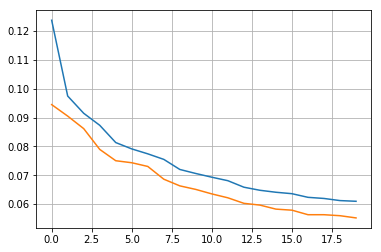

In [71]:
plt.plot(logs['train'])
plt.plot(logs['val'])
plt.grid(True)

In [128]:
torch.save(model.state_dict(), "resnet_34_planet_challenge_30_epochs.pt")

In [129]:
# analyze some predictions
idx = random.randint(0, 4000)
row = labels.iloc[idx]
tags = row.one_hot
image = Image.open('train-jpg/train_' + str(idx) + '.jpg')  # PIL image
image = eval_transformer(image)[:3].unsqueeze(0).cuda()

prediction = model(image)[0].cpu().detach().numpy()
list(prediction)

for i in range(len(prediction)):
    print(tags[i], " --------",  prediction[i])

AttributeError: 'Tensor' object has no attribute 'iloc'

In [118]:
# Get the model's predictions on the entire validation dataset:
np_outputs = []
np_labels = []

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        np_outputs.extend(outputs.cpu().numpy())
        np_labels.extend(labels.cpu().numpy())
        
np_outputs = np.array(np_outputs)
np_labels = np.array(np_labels)

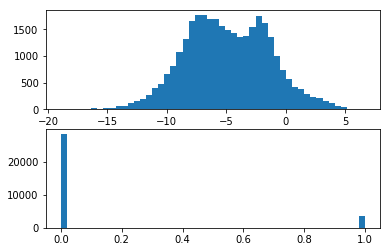

In [139]:
# Generate Histogram of a given column
column = 8
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1.hist(np_outputs[:, column], bins=50);
ax2.hist(np_labels[:, column], bins=50);

## Making predictions on test output:

Iterate through the entire test set and make a list of (filename, outputs) tuples.
Afterwards we'll decode the one-hot encodings and write to a .csv as specified by the kaggle competition. 

In [130]:
# Get all fike
test_filenames = os.listdir("test-jpg")

In [131]:
def decode_onehot(prediction):
    possible_labels = ["agriculture", "artisinal_mine", "bare_ground", "blooming", "blow_down", "clear", "cloudy", "conventional_mine", "cultivation", "habitation", "haze", "partly_cloudy", "primary", "road", "selective_logging", "slash_burn", "water"]
    onehot = [True if i > 0 else False for i in prediction]
    prediction_string = ""
    for i in range(len(onehot)):
        if onehot[i]:
            prediction_string += (" " + possible_labels[i])
            
    return prediction_string[1:]

In [132]:
final_predictions = []

for i in range(len(test_filenames)):
    image = Image.open('test-jpg/' + test_filenames[i])  # PIL image
    image = eval_transformer(image)[:3].unsqueeze(0).cuda()
    output = model(image).cpu().detach().numpy()[0]
    final_predictions.append([test_filenames[i][:-4], decode_onehot(output)])

In [134]:
# write predictions to file:
import csv

with open('predictions2.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['image_name', 'tags'])
    for item in final_predictions:
        writer.writerow([item[0], item[1]])